# BioCRNpyler development
## Workshop Question 1
Create a Mechanism to Model ActivatedTranscription with a hill function

In [20]:
class PositiveHillTranscription(Mechanism):
    #Set the name and mechanism_type
    def __init__(self, name="positivehill_transcription", mechanism_type="transcription"):
        Mechanism.__init__(self, name=name, mechanism_type=mechanism_type)

#     #Overwrite update_species
#     def update_species(self, dna, regulator, transcript = None, **keywords):

#         if transcript is None: #Species names can be automatically created
#             transcript = Species(dna.name, material_type = "rna")

#         return [dna, transcript, regulator] #it is best to return all species that will be involved in the reactions


    #Overwrite update_species
    def update_species(self, dna, activator, transcript = None, **keywords):

        if transcript is None: #Species names can be automatically created
            transcript = Species(dna.name, material_type = "rna")

        return [dna, transcript, activator]
    
    #Overwrite update_reactions
    #This always requires the inputs component and part_id to find the relevant parameters
#     def update_reactions(self, dna, regulator, component, part_id, transcript = None, **keywords):

#         if transcript is None: #Species names should be automatically created the same here as above
#             transcript = Species(dna.name, material_type = "rna")

#         ktx = component.get_parameter("k", part_id = part_id, mechanism = self)
#         n = component.get_parameter("n", part_id = part_id, mechanism = self)
#         K = component.get_parameter("K", part_id = part_id, mechanism = self)
#         kleak = component.get_parameter("kleak", part_id = part_id, mechanism = self)

#         params = {"k":ktx, "n":n, "K":K, "s1":regulator, "d":dna}

#         reaction = Reaction(inputs = [dna], outputs = [dna, transcript],
#                             propensity_type = "proportionalhillpositive", propensity_params = params)

#         reaction_leak = Reaction(inputs = [dna], outputs = [dna, transcript], k = kleak)

    def update_reactions(self, dna, activator, component, part_id, transcript = None, **keywords):

        if transcript is None: #Species names should be automatically created the same here as above
            transcript = Species(dna.name, material_type = "rna")

        ktx = component.get_parameter("k", part_id = part_id, mechanism = self)
        n = component.get_parameter("n", part_id = part_id, mechanism = self)
        K = component.get_parameter("K", part_id = part_id, mechanism = self)
        kleak = component.get_parameter("kleak", part_id = part_id, mechanism = self)

        params = {"k":ktx, "n":n, "K":K, "s1":activator, "d":dna}

        reaction = Reaction(inputs = [dna], outputs = [dna, transcript],
                            propensity_type = "proportionalhillpositive", propensity_params = params)

        reaction_leak = Reaction(inputs = [dna], outputs = [dna, transcript], k = kleak)



        #In this case, we just return one reaction
        return [reaction, reaction_leak]

Component: ActivatablePromoter

In [21]:
class ActivatablePromotor(Promoter):
    def __init__(self, name, activator, transcript = None, **keywords):
        #Set the Regulator
        #Component.set_species(species, material_type = None, attributes = None)
        # is a helper function that allows the input to be a Species, string, or Component.
        self.activator = self.set_species(activator) 
        
        #Mechanisms are inherited from the Mixture unless set specifically in self.default_mechanisms.
        custom_mechanisms = {"transcription": PositiveHillTranscription()}
        
        #Always call the superclass __init__() with **keywords passed through
        Promoter.__init__(self, name = name, transcript = transcript, mechanisms = custom_mechanisms,**keywords)

    def update_species(self, **keywords):
        #Mechanisms are stored in an automatically created dictionary: mechanism_type --> Mechanism Instance.
        mech_tx = self.mechanisms["transcription"]
        
        species = [] #A list of species must be returned
        species += mech_tx.update_species(dna = self.assembly.dna, transcript = self.transcript, activator = self.activator, part_id = self.name+"_"+self.activator.name, component = self)
        
        return species
    
    def update_reactions(self, **keywords):
        mech_tx = self.mechanisms["transcription"]
        
        reactions = [] #a list of reactions must be returned
        reactions += mech_tx.update_reactions(dna = self.assembly.dna, transcript = self.transcript, activator = self.activator, 
                                             component = self, part_id = self.name+"_"+self.activator.name, **keywords) #"ActivatablePromoter_"+
        return reactions
    

Mixture

In [12]:
from biocrnpyler import *

#A Model for Gene Expression without any Machinery (eg Ribosomes, Polymerases, etc.)
class DilutionMixture(Mixture):
    def __init__(self, name="", **keywords):
        
        simple_transcription = SimpleTranscription() #Transcription will not involve machinery
        simple_translation = SimpleTranslation()
        
        default_mechanisms = {
            "transcription": simple_transcription, #This will be overwritten by the NegativeHillPromotor
            "translation": simple_translation
        }
    
        #By Default Species are diluted S-->0 Unless:
        # They are of type 'dna'
        # They have the attribute 'machinery'
        dilution_mechanism = Dilution(filter_dict = {"dna":False}, default_on = True)
        dilution_mrna = Dilution(name = "rna_degredation", filter_dict = {"rna":True}, default_on = False)

        #Add this mechanism to a dictionary which is passed into the Mixture txtl.TxTlExtract
        global_mechanisms = {"dilution":dilution_mechanism, "rna_degredation":dilution_mrna}
        
        #Always call the superclass __init__ with **keywords
        Mixture.__init__(self, name=name, default_mechanisms=default_mechanisms, global_mechanisms = global_mechanisms, **keywords)

Simulate all together

In [22]:
const_lacI = DNAassembly(name = 'pConst', promoter = 'P', rbs = 'BCD2', protein = 'LacI')

LacI = Species('LacI', material_type = 'protein')

pLac = ActivatablePromotor('pLac', transcript = 'TRFP', activator = LacI)

placI_rfp = DNAassembly(name = 'lacI_rfp', promoter = pLac, rbs = 'BCD2', protein = 'RFP')

DM = DilutionMixture(name = 'e coli', components = [const_lacI, placI_rfp], 
                    parameter_file = 'pre_parameters.txt')

CRN = DM.compile_crn()


In [14]:
print(CRN)

Species = protein_LacI, rna_pConst, dna_pConst, protein_RFP, dna_lacI_rfp, rna_lacI_rfp
Reactions = [
	dna_pConst --> dna_pConst + rna_pConst        massaction: k_f(dna_pConst)=0.1875*dna_pConst
	rna_pConst --> rna_pConst + protein_LacI        massaction: k_f(rna_pConst)=3.0*rna_pConst
	dna_lacI_rfp --> dna_lacI_rfp + rna_lacI_rfp        proportionalhillpositive: k(protein_LacI, dna_lacI_rfp)=0.01875*dna_lacI_rfp*protein_LacI^2.0/(20.0+protein_LacI^2.0)
	dna_lacI_rfp --> dna_lacI_rfp + rna_lacI_rfp        massaction: k_f(dna_lacI_rfp)=1e-06*dna_lacI_rfp
	rna_lacI_rfp --> rna_lacI_rfp + protein_RFP        massaction: k_f(rna_lacI_rfp)=3.0*rna_lacI_rfp
	protein_LacI -->         massaction: k_f(protein_LacI)=0.001*protein_LacI
	rna_pConst -->         massaction: k_f(rna_pConst)=0.001*rna_pConst
	protein_RFP -->         massaction: k_f(protein_RFP)=0.001*protein_RFP
	rna_lacI_rfp -->         massaction: k_f(rna_lacI_rfp)=0.001*rna_lacI_rfp
	rna_pConst -->         massaction: k_f(rna_pConst

In [24]:
timepoints = np.linspace(0, 200, 1000)
import bokeh.io
import bokeh.plotting.figure
bokeh.io.output_notebook()

Loading BokehJS ...

In [25]:
import matplotlib.pylab as pylab

In [26]:
R

,protein_LacI,rna_pConst,dna_pConst,protein_RFP,dna_lacI_rfp,rna_lacI_rfp,time
0,0.000000,0.000000,10.0,0.000000e+00,2.0,0.000000e+00,0.000000
1,0.112695,0.375263,10.0,1.251229e-07,2.0,4.482982e-07,0.200200
2,0.450661,0.750300,10.0,7.904077e-07,2.0,2.328739e-06,0.400400
3,1.013716,1.125112,10.0,4.567596e-06,2.0,1.276374e-05,0.600601
4,1.801681,1.499699,10.0,2.140624e-05,2.0,5.012407e-05,0.800801
...,...,...,...,...,...,...,...
995,86223.487381,281.167695,10.0,1.679854e+03,2.0,5.562045e+00,199.199199
996,86375.141727,281.374139,10.0,1.682859e+03,2.0,5.566211e+00,199.399399
997,86526.889656,281.580459,10.0,1.685866e+03,2.0,5.570375e+00,199.599600
998,86678.731074,281.786655,10.0,1.688875e+03,2.0,5.574536e+00,199.799800


In [28]:
timepoints = np.linspace(0, 200, 1000)
color_list = ["red", "purple", "blue"]
p = bokeh.plotting.figure()

for ind, pconst_lacI0 in enumerate([0, 1, 10]):
    x0_dict = {repr(const_lacI.get_species()): pconst_lacI0, repr(placI_rfp.get_species()): 2}
    
    R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0_dict, stochastic = False)
    
    p.circle(timepoints, R[str(LacI)])
#     plt.plot(timepoints, R[str(LacI)], ":", label = "LacI [pConstLacI] = "+str(pconst_lacI0), color = color_list[ind])
#     plt.plot(timepoints, R["protein_RFP"], label = "RFP [pConstLacI] = "+str(pconst_lacI0), color = color_list[ind])




# x0_dict = {'dna_pConst': 10, 'dna_lacI_rfp': 2}

# R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0_dict, stochastic = False)

# p = bokeh.plotting.figure(width = 450, height = 300)

# p.circle(timepoints, R[str(LacI)])

bokeh.io.show(p)

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


{'dna_pConst': 10, 'dna_lacI_rfp': 2}


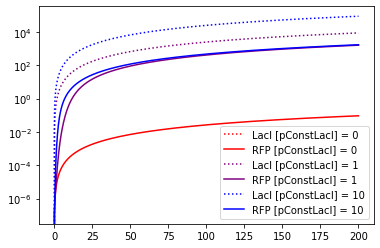

In [15]:
timepoints = np.linspace(0, 200, 1000)
import pylab as plt
color_list = ["red", "purple", "blue"]
for ind, pconst_lacI0 in enumerate([0, 1, 10]):
    x0_dict = {repr(const_lacI.get_species()): pconst_lacI0, repr(placI_rfp.get_species()): 2}
    
    R = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0_dict, stochastic = False)

    plt.plot(timepoints, R[str(LacI)], ":", label = "LacI [pConstLacI] = "+str(pconst_lacI0), color = color_list[ind])
    plt.plot(timepoints, R["protein_RFP"], label = "RFP [pConstLacI] = "+str(pconst_lacI0), color = color_list[ind])

print(x0_dict)

plt.legend()
plt.yscale('log')